# Notebook for single trial PCA
## single reach stim trials only, 50ms before lift to 300ms after behavior ends (assuming 260ms for at mouth)
## Applying Kalman filter (Q=1e-3, no baseline firing rate)

In [1]:
from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, get_trial_PCA
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from matplotlib import colormaps

In [2]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [3]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data = {field: data_struct[field] for field in mat.dtype.names}

In [4]:
data.keys()

dict_keys(['totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success'])

# Get single-reach stim trials

In [5]:
# get no laser trials
control_idxs = np.where(data["pattern_id"][:150] > 2)[0] 

In [6]:
#control_idxs = np.sort(np.concatenate((a, b)))
control_idxs

array([ 17,  19,  20,  22,  23,  24,  28,  29,  30,  34,  35,  36,  40,
        43,  44,  46,  49,  50,  53,  54,  56,  60,  61,  62,  65,  66,
        67,  70,  71,  74,  77,  79,  80,  82,  83,  86,  88,  89,  91,
        94,  95,  96, 100, 101, 102, 106, 107, 108, 114, 115, 116, 118,
       119, 120, 124, 127, 128, 131, 132, 133])

### Only want to look at single reach trials

In [7]:
single_idxs = np.where(data["single"] == 1)[1]
single_idxs

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        16,  17,  18,  19,  20,  21,  23,  24,  26,  30,  33,  36,  37,
        38,  39,  40,  41,  43,  44,  45,  46,  48,  49,  50,  51,  52,
        53,  54,  58,  60,  61,  62,  63,  67,  68,  69,  70,  71,  73,
        74,  77,  78,  81,  82,  84,  85,  88,  89,  91, 105, 107, 109,
       116, 117, 121, 122, 130, 137, 139, 145, 148])

In [8]:
control_idxs = np.intersect1d(control_idxs, single_idxs)
control_idxs

array([ 17,  19,  20,  23,  24,  30,  36,  40,  43,  44,  46,  49,  50,
        53,  54,  60,  61,  62,  67,  70,  71,  74,  77,  82,  88,  89,
        91, 107, 116])

In [9]:
control_idxs.shape

(29,)

In [10]:
np.unique(data["pattern_id"][control_idxs])

array([14, 17, 20], dtype=uint8)

## Get relevant time information

In [11]:
cue_times = data["cue_rec_time"][:, :150]
cue_times[:, control_idxs]

array([[ 378401.3027471 ,  412964.5048617 ,  430223.16624186,
         481960.06796941,  499231.75682054,  603021.71245162,
         706335.69338242,  775155.48003398,  826860.47389786,
         844093.36354196,  878540.9232512 ,  930339.75266686,
         947557.06598697,  999343.5287454 , 1016540.9232512 ,
        1120486.35891627, 1137781.83706221, 1155099.87727745,
        1241575.09676201, 1293329.17964694, 1310604.83338053,
        1362412.63098272, 1414270.55602757, 1500421.5047673 ,
        1604049.56103087, 1621268.29038044, 1655724.06306051,
        1932015.76512791, 2087651.09034268]])

In [12]:
lift_times = data["lift_ms"][:, :150]
lift_times[:, control_idxs]

array([[290., 200., 280., 270., 270., 300., 290., 310., 270., 320., 290.,
        250., 270., 280., 270., 290., 270., 270., 260., 320., 310., 310.,
        280., 340., 270., 300., 310., 300., 290.]])

In [13]:
mouth_times = data["mouth_ms"][:, :150]
mouth_times[:, control_idxs]

array([[520., 510., 630., 480., 520., 570., 670., 570., 510., 640., 560.,
        480., 520., 490., 590., 520., 550., 570., 520., 550., 580., 650.,
        510., 570., 480., 570., 550., 530., 500.]])

In [14]:
p_ids = np.unique(data["pattern_id"][control_idxs])
p_ids

array([14, 17, 20], dtype=uint8)

## Get the AP.bin file

In [15]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [16]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [17]:
meta_data = get_meta(meta_path)

In [18]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [19]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [20]:
vmax

0.6

In [21]:
imax

512.0

In [22]:
gain

500.0

## Get first trial

#### 50ms before "lift" to 300ms after behavior

In [23]:
trial_no = control_idxs[0]
trial_no

17

In [24]:
# get the lift time in ap units 
# cue + lift time (ms) / 1000 = s * 30_000 (sR) 
start_lift = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)

# # get end of lift
# end_lift = int((cue_times[:, trial_no] + grab_times[:, trial_no] + 300) / 1_000 * 30_000)

# get end of behavior = mouth (260ms) + 300ms 
end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260 + 300) / 1_000 * 30_000)
(start_lift, end_behavior)

(11359239, 11384439)

In [25]:
trial_one = ap_data[:150, start_lift:end_behavior]
trial_one.shape

(150, 25200)

In [26]:
data["laser_rec_time"][0, 17] / 1_000 * 30_000

11352039.082412913

# Get median segment
Taking a baseline of 2 seconds of data before cue

In [27]:
c_start = int(cue_times[:, trial_no] / 1_000 * 30_000)
m_start = c_start - (30 * 2000)
trial_median = ap_data[:150, m_start:c_start]
trial_median.shape

(150, 60000)

## Convert to microvolts 

In [28]:
conv_data = 1e6 * trial_one / vmax / imax / gain

In [29]:
conv_data.shape

(150, 25200)

## Filter

In [30]:
filt_data = butter_filter(conv_data, 1_000, 30_000)
filt_data.shape

(150, 25200)

## Median/MAD Threshold 

In [31]:
trial_median = 1e6 * trial_median / vmax / imax / gain
trial_median = butter_filter(trial_median, 1_000, 30_000)

median = np.median(trial_median, axis=1)
median.shape

(150,)

In [32]:
spike_ixs, counts = get_spike_events(filt_data, median)

In [33]:
# create a range of the entire trial time
# binarize the spike times
# bin into 5ms bins (every 150 data points) 

In [34]:
a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

In [35]:
for i, sc in enumerate(spike_ixs):
    a[i, sc] = 1

## Bin the spike data

In [36]:
bin_size = 40 # 10ms * 30 points per 1ms

In [37]:
b = bin_size * 30
binned_spikes = bin_spikes(a, bin_size=b)

In [38]:
binned_spikes.shape

(150, 21)

## Apply kalman filter

In [43]:
#binned = np.random.poisson(0.5, (4, 100))  # fake binned data
smoothed = kalman_filter(binned_spikes, Q=1e-2)


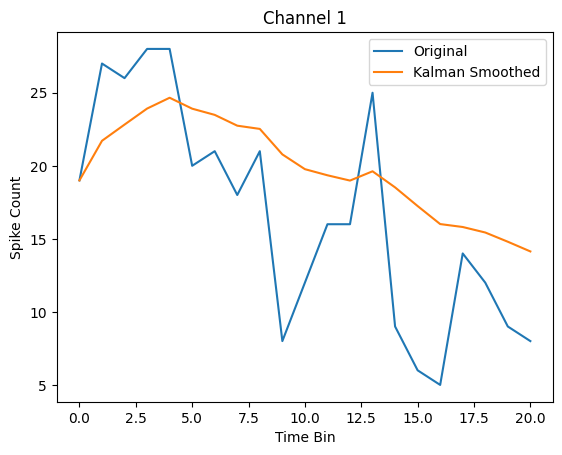

In [44]:
import matplotlib.pyplot as plt

plt.plot(binned_spikes[1], label='Original')
plt.plot(smoothed[1], label='Kalman Smoothed')
plt.legend()
plt.title('Channel 1')
plt.xlabel('Time Bin')
plt.ylabel('Spike Count')
plt.show()


In [45]:
smoothed.shape

(150, 21)

In [46]:
# lift duration
lift = int(data["lift_ms"][0,trial_no] / bin_size) 
# grab duration
grab = int(data["grab_ms"][0,trial_no] / bin_size)
# mouth duration 
mouth = int(data["mouth_ms"][0,trial_no] / bin_size)

(lift, grab, mouth)

(7, 9, 13)

In [47]:
pca = PCA(n_components=6)

# Fit the PCA model to the data and transform the data
# only fit the PCA on 50ms before lift to end of lift 
lift_start = int(50 / bin_size)
after_lift = int(300 / bin_size) + lift_start

#d = smoothed - smoothed.mean(axis=1, keepdims=True)

#d = smoothed[:,:after_lift] - smoothed[:,:after_lift].mean(axis=1, keepdims=True)

pca.fit(smoothed[:, :after_lift].T)
reduced_data = pca.transform(smoothed.T)

print("Explained variance ratio by each principal component:", pca.explained_variance_ratio_)
print("Total explained variance ratio", pca.explained_variance_ratio_[:3].sum())

Explained variance ratio by each principal component: [0.84055553 0.10279041 0.03546744 0.01135072 0.00529595 0.0027781 ]
Total explained variance ratio 0.9788133820707641


In [48]:
reduced_data.shape

(21, 6)

# Plot single trial in 2D

Explained variance ratio by each principal component: [0.84055553 0.10279041 0.03546744 0.01135072 0.00529595 0.0027781 ]
Total explained variance (top 3 PCs): 0.9788133820707641


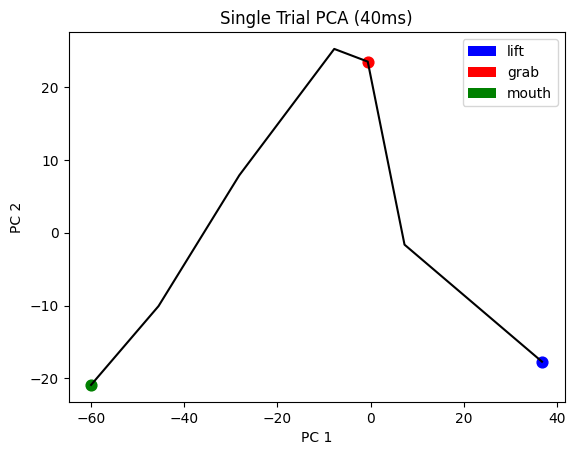

In [49]:
# Print explained variance ratio
print("Explained variance ratio by each principal component:", pca.explained_variance_ratio_)
print("Total explained variance (top 3 PCs):", pca.explained_variance_ratio_[:3].sum())


mouth_start = lift_start + (mouth-lift)

# # Visualize the reduced data (scatter plot)
#p = gaussian_filter1d(reduced_data, sigma=1)
p = reduced_data
plt.plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], c="black")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(f"Single Trial PCA ({bin_size}ms)")

plt.scatter(p[lift_start, 0], p[lift_start, 1], s=60, c="blue")
plt.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], s=60, c="red")
plt.scatter(p[mouth_start, 0], p[mouth_start, 1], s=60, c="green")

from matplotlib.patches import Patch

# Sample color mapping
c = {'lift': 'blue', 'grab': 'red', 'mouth': 'green'}

# Manual legend
legend_elements = [Patch(facecolor=color, label=beh) for beh, color in c.items()]
plt.legend(handles=legend_elements)
plt.show()

# Plot single trial in 3D

Explained variance ratio by each principal component: [0.84055553 0.10279041 0.03546744 0.01135072 0.00529595 0.0027781 ]
Total explained variance (top 3 PCs): 0.97881


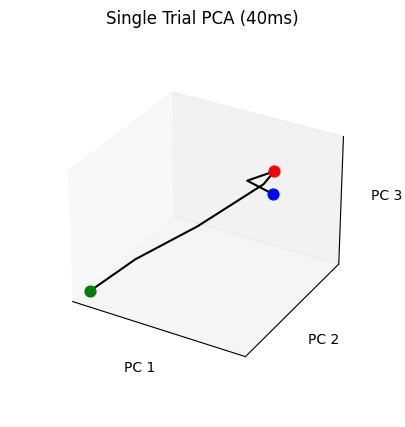

In [59]:
# Print explained variance ratio
print("Explained variance ratio by each principal component:", pca.explained_variance_ratio_)
print("Total explained variance (top 3 PCs):", round(pca.explained_variance_ratio_[:3].sum(), 5))

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')


mouth_start = lift_start + (mouth-lift)

# # Visualize the reduced data (scatter plot)
p = gaussian_filter1d(reduced_data, sigma=0.5)
#p = reduced_data
ax.plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c="black")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title(f"Single Trial PCA ({bin_size}ms)")

ax.scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=60, c="blue")
ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=60, c="red")
ax.scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=60, c="green")

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# from matplotlib.patches import Patch

# # Sample color mapping
# c = {'lift': 'blue', 'grab': 'red', 'mouth': 'green'}

# # Manual legend
# legend_elements = [Patch(facecolor=color, label=beh) for beh, color in c.items()]
# plt.legend(handles=legend_elements)
ax.set_box_aspect(None, zoom=0.8)
plt.show()

# Patterns reconstructed

In [23]:
# visualize the patterns again
pattern_ids = list(np.unique(data['pattern_id']))
len(pattern_ids)

30

In [24]:
#reshape_size = 12
pattern_ids = list(np.unique(data['pattern_id']))
all_patterns = list()
# pattern 0 = no laser
all_patterns.append(np.zeros((12, 12)))
# pattern 1 = full field
all_patterns.append(np.ones((12, 12)))
# pattern 2 = empty field 
all_patterns.append(np.zeros((12, 12)))
for p_id in pattern_ids[3:]:
    ix = np.where(data['pattern_id'] == p_id)[0][0].astype(np.int32)
    pattern = np.zeros((data['pattern_xy'][ix][0].astype(np.int32), data['pattern_xy'][ix][1].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = data['pattern_fill'][0][ix]
    for x, y in zip(object_ref[:, 0], object_ref[:, 1]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    all_patterns.append(pattern)

    #pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    #interp_patterns.append(pattern)

# PCA on all trials for each pattern condition

In [25]:
all_data = list()

# HYPERPARAMETERS TO TOGGLE
bin_size = 5
Q=1e-2

p_colors = list()
c = {14: "cyan", 17: "magenta", 20: "orange"}

for i in tqdm(control_idxs):
    trial_no = i
    p_colors.append(c[data["pattern_id"][i][0]])
    # get time points in ap space
    lift_time = int((cue_times[:, trial_no] + lift_times[:, trial_no] - 50) / 1_000 * 30_000)
    
    # get end of behavior = mouth (260ms) + 300ms 
    end_behavior = int((cue_times[:, trial_no] + mouth_times[:, trial_no] + 260) / 1_000 * 30_000)
    #print(lift_time, end_behavior)

    trial = ap_data[:150, lift_time:end_behavior]

    conv_data = 1e6 * trial / vmax / imax / gain

    filt_data = butter_filter(conv_data, 1_000, 30_000)

    c_start = int(cue_times[:, trial_no] / 1_000 * 30_000)
    m_start = c_start - (30 * 2000)
    trial_median = ap_data[:150, m_start:c_start]

    trial_median = 1e6 * trial_median / vmax / imax / gain
    trial_median = butter_filter(trial_median, 1_000, 30_000)
    
    median = np.median(trial_median, axis=1)

    spike_ixs, counts = get_spike_events(filt_data, median)
    
    a = np.zeros((filt_data.shape[0], filt_data.shape[1]))

    for i, sc in enumerate(spike_ixs):
        a[i, sc] = 1

    b = bin_size * 30 # 30ms per bin
    binned_spikes = bin_spikes(a, b)

    smoothed = kalman_filter(binned_spikes, Q=Q)

    all_data.append(smoothed)

100%|█████████████████████████████████| 29/29 [03:32<00:00,  7.33s/it]


# Pattern 14

Text(0.5, 1.0, 'Pattern 14')

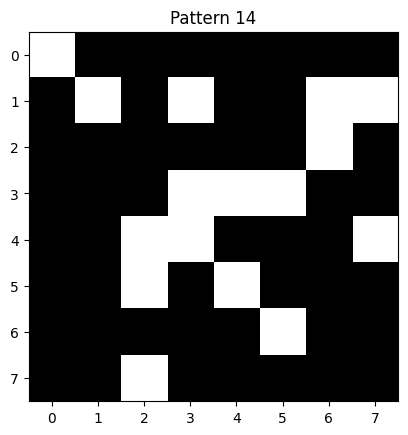

In [26]:
plt.imshow(all_patterns[14], cmap="binary", vmin=0, vmax=1)
plt.title("Pattern 14")

In [28]:
ixs = np.where(data["pattern_id"][control_idxs] == 14)[0]
print(ixs)

sub_data = [all_data[i] for i in ixs]

[ 0  5  9 11 14 15 21 26]


In [29]:
pca = PCA(n_components=6)

pca_data = list()

lift_start = int(50 / bin_size)
after_lift = int(300 / bin_size) + lift_start

for d in sub_data:
    pca_data.append(d[:, lift_start:after_lift])

d = np.concatenate(pca_data, axis=1)
    
pca.fit(d.T)

pca.explained_variance_ratio_

array([0.51924054, 0.12167532, 0.05081844, 0.03266691, 0.02879592,
       0.02582247])

In [30]:
pca.explained_variance_ratio_[:3].sum()

0.6917343029250002

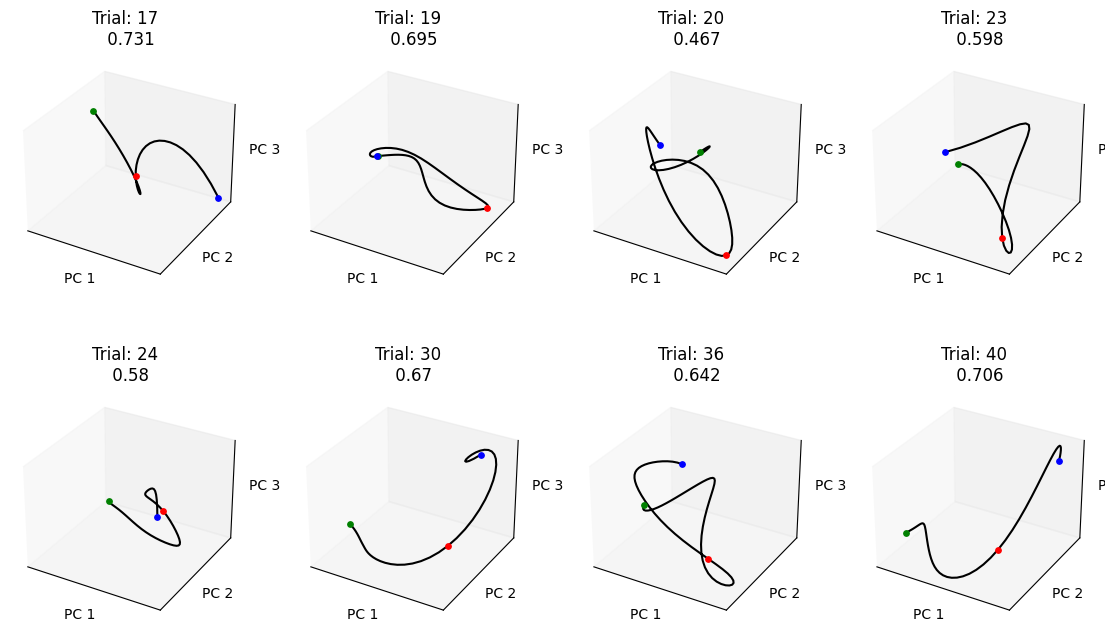

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(14, 8), subplot_kw=dict(projection='3d'))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(sub_data):

    explained_var, p = get_trial_PCA(p, pca)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    p = gaussian_filter1d(p, sigma=5, axis=0)

    #axes[i].scatter(p[:, 0], p[:, 1], s=1, c=colors)
    axes[i].plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c="black")
    axes[i].set_xlabel(f"PC 1", labelpad=-7)
    axes[i].set_ylabel(f"PC 2", labelpad=-7)
    axes[i].set_zlabel(f"PC 3", labelpad=-7)
    axes[i].set_title(f"Trial: {control_idxs[i]} \n {round(explained_var.sum(), 3)}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_zticks([])


    axes[i].scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=15, c="blue")
    axes[i].scatter(p[grab_start, 0], p[grab_start, 1], p[grab_start, 2], s=15, c="red")
    axes[i].scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=15, c="green")

plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/PCA_stim_pattern_{14}_{bin_size}ms.png")

# Pattern 17

Text(0.5, 1.0, 'Pattern 17')

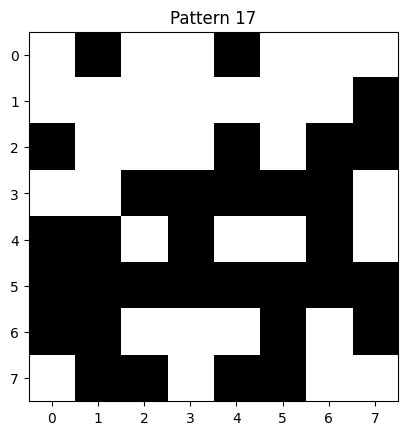

In [32]:
plt.imshow(all_patterns[17], cmap="binary", vmin=0, vmax=1)
plt.title("Pattern 17")

In [33]:
ixs = np.where(data["pattern_id"][control_idxs] == 17)[0]
print(ixs)

sub_data = [all_data[i] for i in ixs]

[ 1  3  6  7 12 13 16 18 20 23 25 27 28]


In [34]:
pca = PCA(n_components=6)

pca_data = list()

lift_start = int(50 / bin_size)
after_lift = int(300 / bin_size) + lift_start

for d in sub_data:
    pca_data.append(d[:, lift_start:after_lift])

d = np.concatenate(pca_data, axis=1)
    
pca.fit(d.T)

pca.explained_variance_ratio_

array([0.46530207, 0.12619176, 0.04423822, 0.03660044, 0.02949234,
       0.02277886])

In [35]:
pca.explained_variance_ratio_[:3].sum()

0.6357320543901045

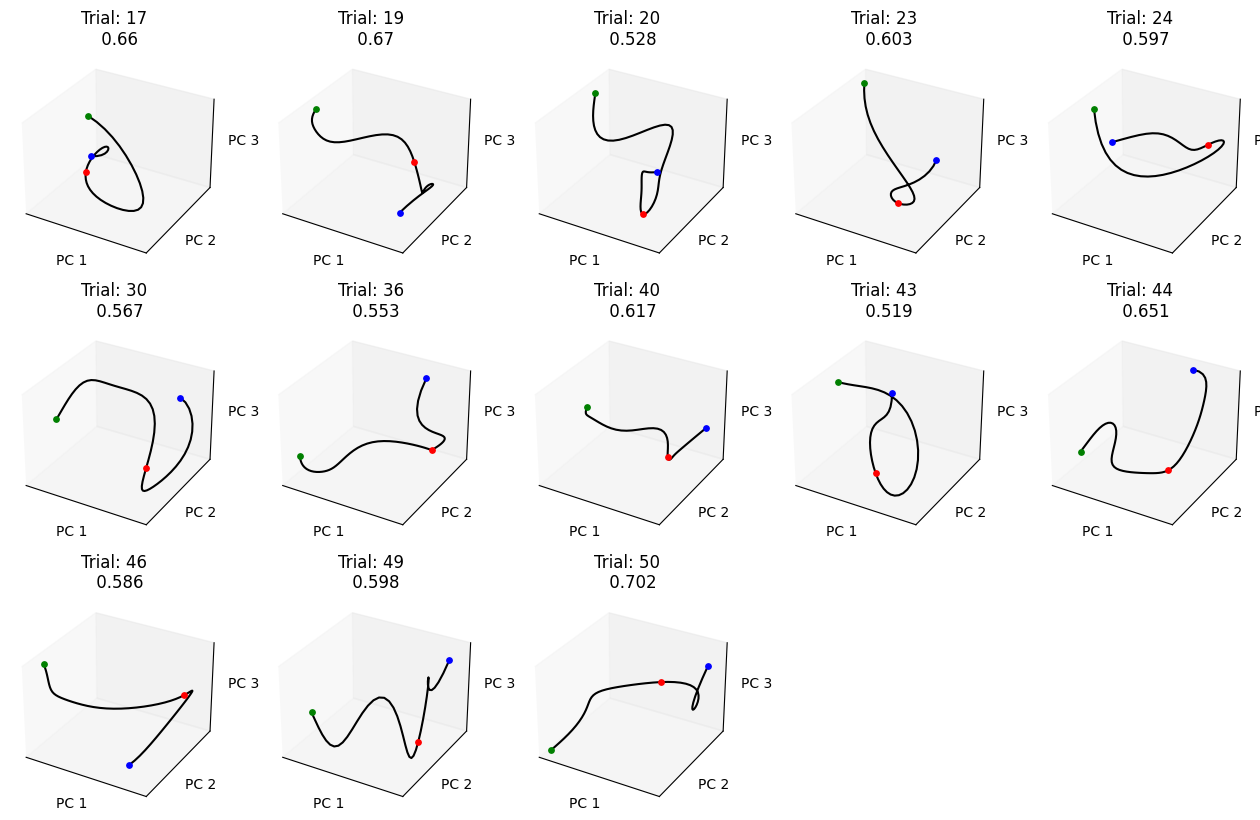

In [36]:
fig, axes = plt.subplots(3, 5, figsize=(16, 10), subplot_kw=dict(projection='3d'))

# Flatten axes array for easy iteration
axes = axes.flatten()

ixs = np.where(data["pattern_id"][control_idxs] == 17)[0]

sub_data = [all_data[i] for i in ixs]

for i, p in enumerate(sub_data):

    explained_var, p = get_trial_PCA(p, pca)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    p = gaussian_filter1d(p, sigma=5, axis=0)

    #axes[i].scatter(p[:, 0], p[:, 1], s=1, c=colors)
    axes[i].plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c="black")
    axes[i].set_xlabel(f"PC 1", labelpad=-7)
    axes[i].set_ylabel(f"PC 2", labelpad=-7)
    axes[i].set_zlabel(f"PC 3", labelpad=-7)
    axes[i].set_title(f"Trial: {control_idxs[i]} \n {round(explained_var.sum(), 3)}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_zticks([])


    axes[i].scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=15, c="blue")
    axes[i].scatter(p[grab_start, 0], p[grab_start, 1], p[grab_start, 2], s=15, c="red")
    axes[i].scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=15, c="green")

axes[-1].remove() 
axes[-2].remove() 

plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/PCA_stim_pattern_{17}_{bin_size}ms.png")

# Pattern 20

Text(0.5, 1.0, 'Pattern 20')

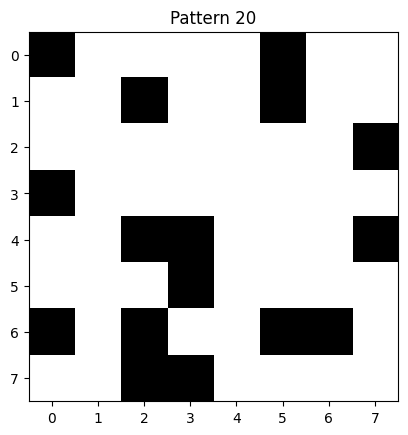

In [37]:
plt.imshow(all_patterns[20], cmap="binary", vmin=0, vmax=1)
plt.title("Pattern 20")

In [38]:
ixs = np.where(data["pattern_id"][control_idxs] == 20)[0]
print(ixs)

sub_data = [all_data[i] for i in ixs]

[ 2  4  8 10 17 19 22 24]


In [39]:
pca = PCA(n_components=6)

pca_data = list()

lift_start = int(50 / bin_size)
after_lift = int(300 / bin_size) + lift_start

for d in sub_data:
    pca_data.append(d[:, lift_start:after_lift])

d = np.concatenate(pca_data, axis=1)
    
pca.fit(d.T)

pca.explained_variance_ratio_

array([0.48573426, 0.12371216, 0.04941931, 0.03771608, 0.03007146,
       0.02569783])

In [40]:
pca.explained_variance_ratio_[:3].sum()

0.6588657205100047

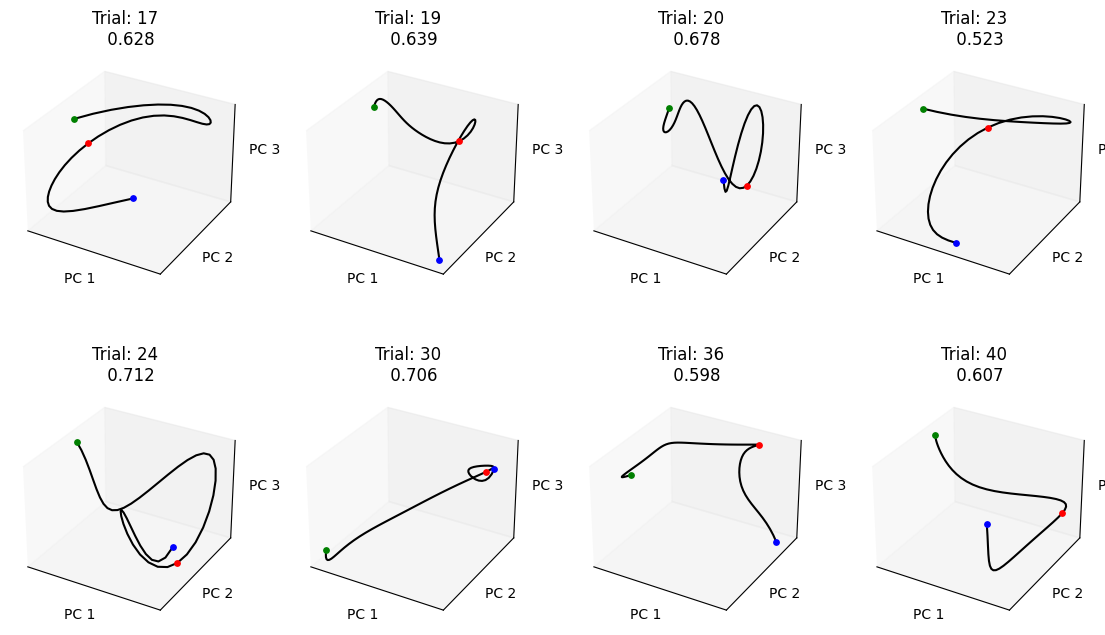

In [41]:
fig, axes = plt.subplots(2, 4, figsize=(14, 8), subplot_kw=dict(projection='3d'))

# Flatten axes array for easy iteration
axes = axes.flatten()

ixs = np.where(data["pattern_id"][control_idxs] == 20)[0]

sub_data = [all_data[i] for i in ixs]

for i, p in enumerate(sub_data):

    explained_var, p = get_trial_PCA(p, pca)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    p = gaussian_filter1d(p, sigma=5, axis=0)

    #axes[i].scatter(p[:, 0], p[:, 1], s=1, c=colors)
    axes[i].plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c="black")
    axes[i].set_xlabel(f"PC 1", labelpad=-7)
    axes[i].set_ylabel(f"PC 2", labelpad=-7)
    axes[i].set_zlabel(f"PC 3", labelpad=-7)
    axes[i].set_title(f"Trial: {control_idxs[i]} \n {round(explained_var.sum(), 3)}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_zticks([])


    axes[i].scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=15, c="blue")
    axes[i].scatter(p[grab_start, 0], p[grab_start, 1], p[grab_start, 2], s=15, c="red")
    axes[i].scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=15, c="green")

plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/PCA_stim_pattern_{20}_{bin_size}ms.png")

# PCA on all stim conditions

In [27]:
pca = PCA(n_components=6)

pca_data = list()

lift_start = int(50 / bin_size)
after_lift = int(300 / bin_size) + lift_start

for d in all_data:
    pca_data.append(d[:, lift_start:after_lift])

d = np.concatenate(pca_data, axis=1)
    
pca.fit(d.T)

pca.explained_variance_ratio_

array([0.47567624, 0.1218661 , 0.03623241, 0.03187645, 0.02383033,
       0.02071664])

In [28]:
pca.explained_variance_ratio_[:3].sum()

0.6337747513602497

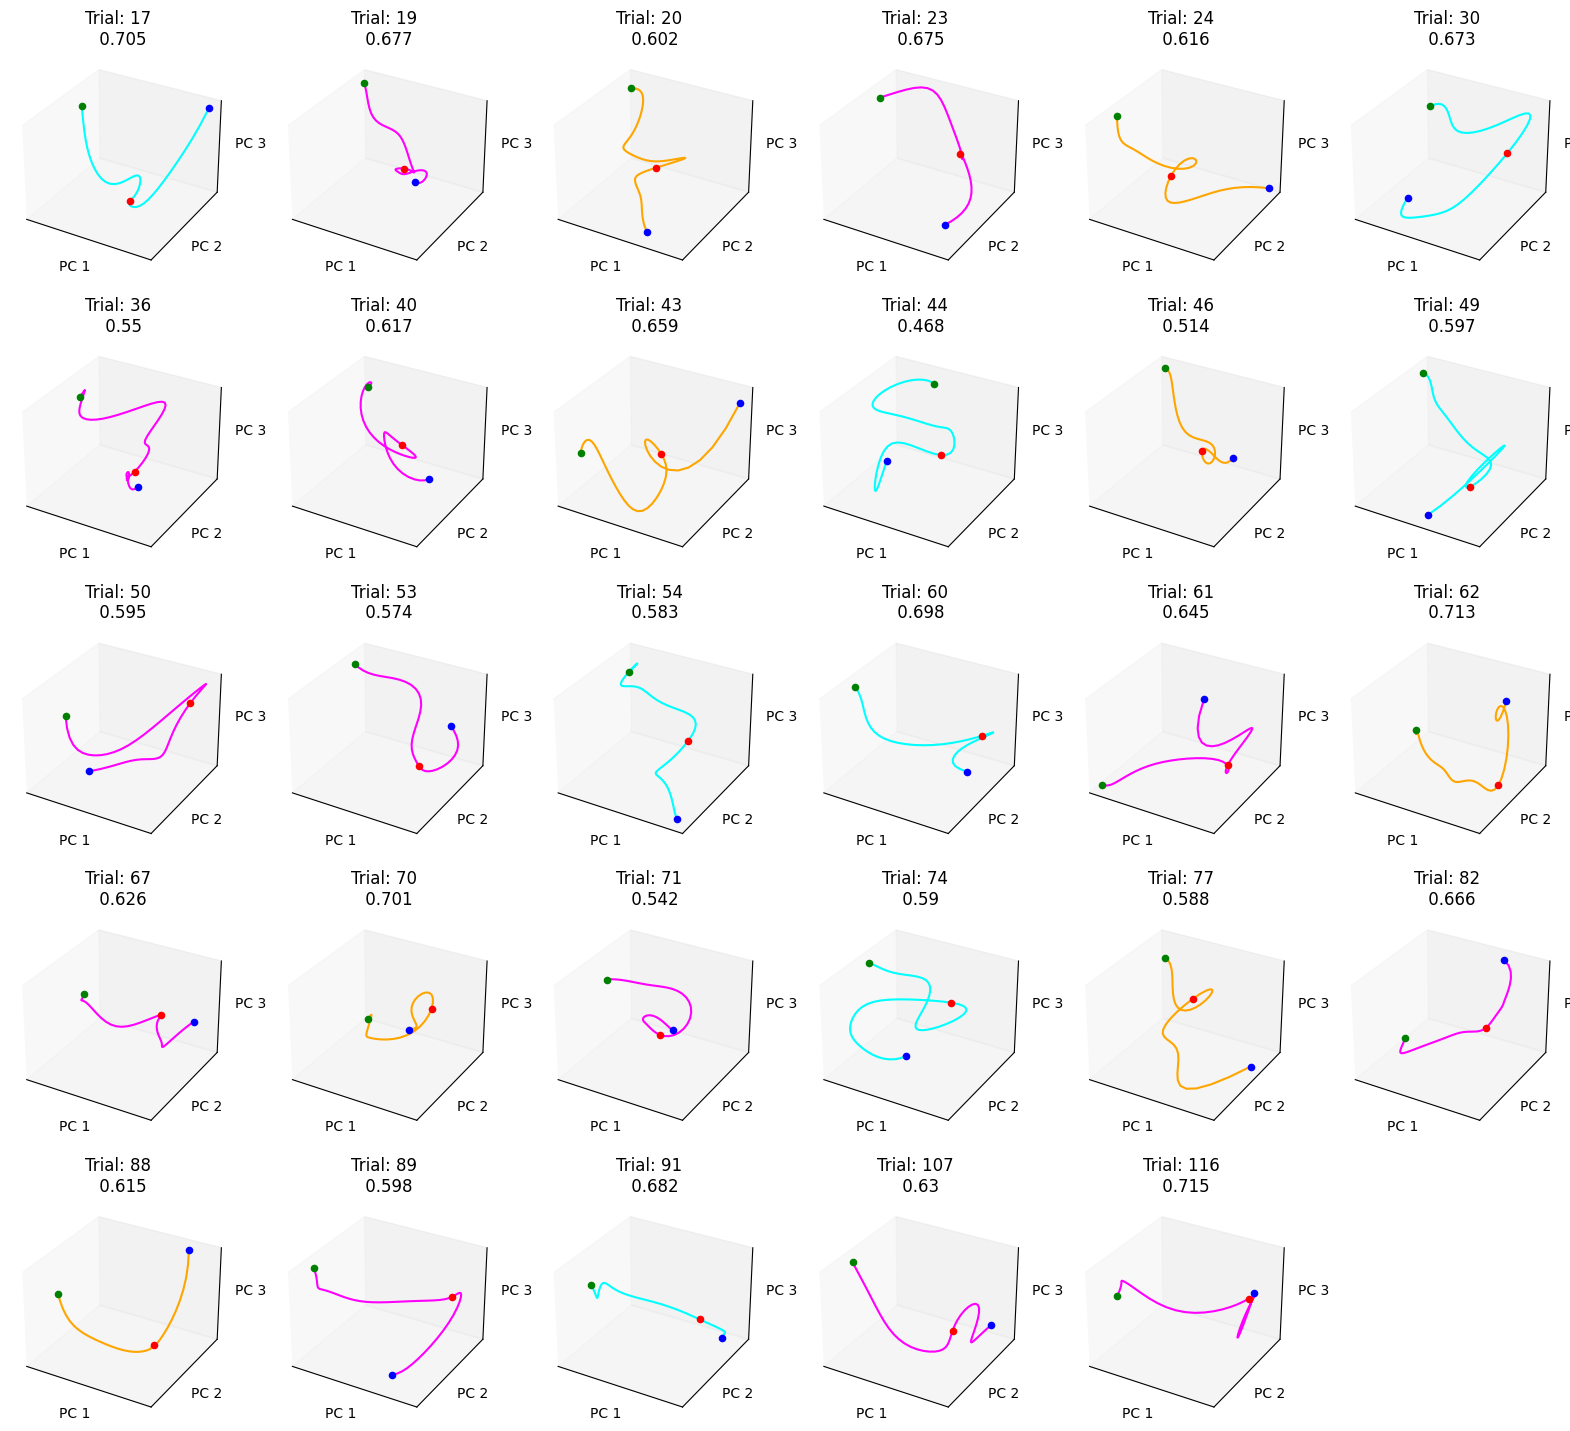

In [29]:
fig, axes = plt.subplots(5, 6, figsize=(20, 18), subplot_kw=dict(projection='3d'))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(all_data):

    explained_var, p = get_trial_PCA(p, pca)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    p = gaussian_filter1d(p, sigma=4, axis=0)

    #axes[i].scatter(p[:, 0], p[:, 1], s=1, c=colors)
    axes[i].plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c=p_colors[i])
    axes[i].set_xlabel(f"PC 1", labelpad=-7)
    axes[i].set_ylabel(f"PC 2", labelpad=-7)
    axes[i].set_zlabel(f"PC 3", labelpad=-7)
    axes[i].set_title(f"Trial: {control_idxs[i]} \n {round(explained_var.sum(), 3)}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_zticks([])


    axes[i].scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=20, c="blue")
    axes[i].scatter(p[grab_start, 0], p[grab_start, 1], p[grab_start, 2], s=20, c="red")
    axes[i].scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=20, c="green")

axes[-1].remove() 

plt.savefig(f'/home/clewis/repos/realSpike/data/rb50_20250127/PCA_stim_{bin_size}ms_3d.png')

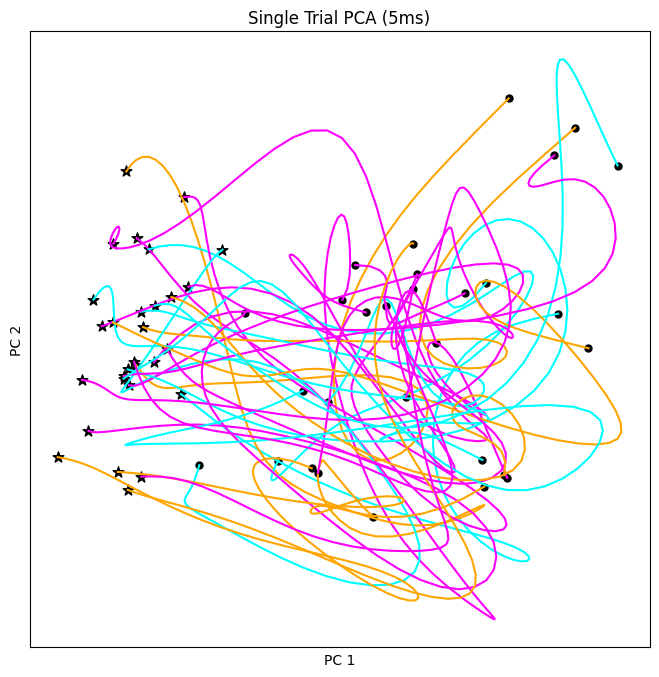

In [32]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

n_colors = len(all_data)
cmap = colormaps['viridis']
colors = cmap(np.linspace(0, 1, n_colors))


for i, p in enumerate(all_data):

    explained_var, p = get_trial_PCA(p, pca)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    p = gaussian_filter1d(p, sigma=4, axis=0)
    
#p = reduced_data
    ax.plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], c=p_colors[i])

    ax.scatter(p[lift_start, 0], p[lift_start, 1], s=25, c="black")
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    ax.scatter(p[mouth_start, 0], p[mouth_start, 1], s=65, marker='*', c="black")


ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title(f"Single Trial PCA ({bin_size}ms)")



ax.set_xticks([])
ax.set_yticks([])

# from matplotlib.patches import Patch

# # Sample color mapping
# c = {'lift': 'blue', 'grab': 'red', 'mouth': 'green'}

# # Manual legend
# legend_elements = [Patch(facecolor=color, label=beh) for beh, color in c.items()]
# plt.legend(handles=legend_elements)
#ax.set_box_aspect(None, zoom=0.8)
plt.savefig(f'/home/clewis/repos/realSpike/data/rb50_20250127/PCA_stim_all_{bin_size}ms_2d.png')
plt.show()

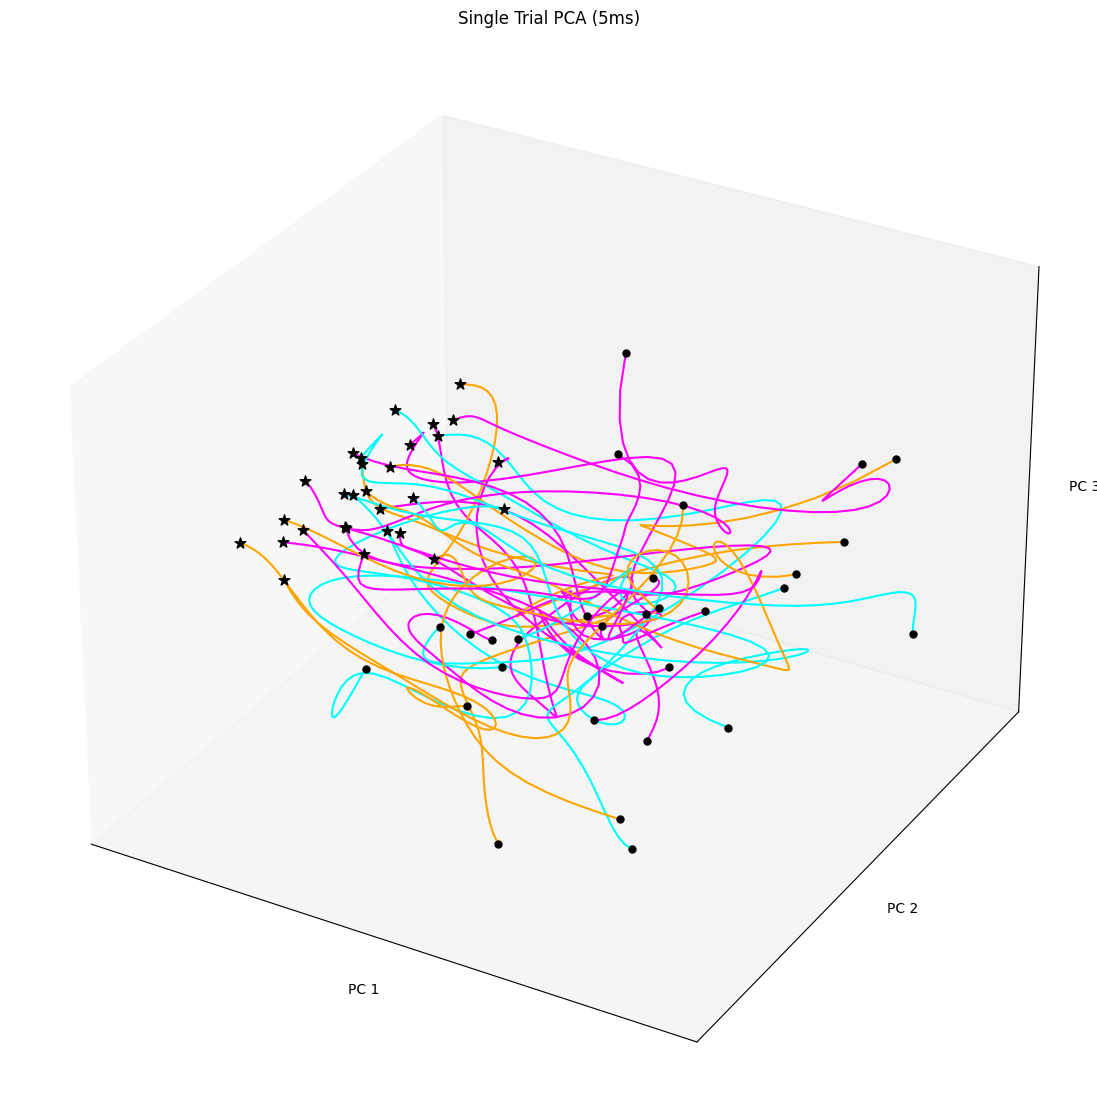

In [33]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

for i, p in enumerate(all_data):

    explained_var, p = get_trial_PCA(p, pca)
    
    lift = int(data["lift_ms"][0, control_idxs[i]] / bin_size) 
    # grab duration
    grab = int(data["grab_ms"][0,control_idxs[i]] / bin_size)
    # mouth duration 
    mouth = int(data["mouth_ms"][0,control_idxs[i]] / bin_size)

    lift_start = int(50 / bin_size)
    grab_start = lift_start + (grab - lift)
    mouth_start = lift_start + (mouth-lift)

    # p = gaussian_filter1d(p, sigma=0.05)
    p = gaussian_filter1d(p, sigma=4, axis=0)
    
#p = reduced_data
    ax.plot(p[lift_start:mouth_start+1, 0], p[lift_start:mouth_start+1, 1], p[lift_start:mouth_start+1, 2], c=p_colors[i])

    ax.scatter(p[lift_start, 0], p[lift_start, 1], p[lift_start, 2], s=25, c="black")
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    ax.scatter(p[mouth_start, 0], p[mouth_start, 1], p[mouth_start, 2], s=65, marker="*", c="black")


ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title(f"Single Trial PCA ({bin_size}ms)")



ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# from matplotlib.patches import Patch

# # Sample color mapping
# c = {'lift': 'blue', 'grab': 'red', 'mouth': 'green'}

# # Manual legend
# legend_elements = [Patch(facecolor=color, label=beh) for beh, color in c.items()]
# plt.legend(handles=legend_elements)
#ax.set_box_aspect(None, zoom=0.8)
plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/PCA_stim_all_{bin_size}ms_3d.png")
plt.show()